# Research Code

## Imports
Nothing important, maybe will need to look at citations for these code libraries
- pandas: https://pandas.pydata.org/
- 

In [1]:
from config import pop_sex_to_stratified, pop_race_to_stratified, rng
from config import accuracy_score, f1_score, recall_score, precision_score, \
    classification_report, confusion_matrix, ConfusionMatrixDisplay, \
        graphviz, go, plt
from helpers_data import *
from helpers_model import *

## Load Data

In [9]:
# ONLY RUN THIS ONCE; expensive, and the data is already saved (load)

mode = "load" # "load" or "generate" 
if mode == "load":
    data_stimulated = load_model_data()
else:
    # see steps below in markdown
    data = load_data() # brfss data load
    data = drop_unwanted(data) # drop unwanted columns
    pop_data = load_data(data_set="census") # load census data
    stratified_data = get_stratified_data(data) # get stratified data
    data_stimulated = generate_stimulated_base(data, pop_data) # generate stimulated data BASE
    data_stimulated = stimulate_data(data_stimulated, stratified_data, mode="both") # stimulate data
    data_stimulated = encode_data(data_stimulated) # encode data (categorical values)
    save_data(data_stimulated) # save dataset

## Trim
1. Get rid of all unused topics.
2. Get rid of empty entries
    - for future research, possibly add these categories in with new data
3. Get rid of dropped entries (see section on `Methodology` below)

## Methodology

1. Get U.S. population counts for `age groups`, `ethnicities/gender`, and `regions` from `2015-2022`
    - Ages
        - `65 years or older`
        - `50-64 years`
        - `Overall` ——— Below 50
    - Gender/Ethnicities
        - `FEMALE`
        - `MALE`
        - `Overall` ——— other/all [gender only]
        - `WHT` ——— White
        - `BLK` ——— Black
        - `HIS` ——— Hispanic
        - `NAA` ——— Native American
        - `ASN` ——— Asian
    - Regions
        - `United States, DC & Territories` [DROP]
        - `West` [DROP]
        - `South` [DROP]
        - `Midwest` [DROP]
        - `Northeast` [DROP]
        - 50 states & D.C. [individually] 
        - `Puerto Rico` [DROP]
        - `Guam` [DROP]
        - `Virgin Islands` [DROP]
3. Stimulate the U.S. using these populations and responses to the question
    - Assign everyone `known Alzheimer's patient` or `apparently no Alzheimer's`
4. Stimulate features using probabilities for patients and non-patients


## Stimulate Data
### Load Census Data
Population data obtained from the U.S. Census

### Go by year
NOTE: Data has a 90% confidence interval, and will be sample as such

- Onehot encode AGE_GROUP, NAME, SEX, and RACE
- first cast to letters

## Model

In [11]:
X_train, X_test, y_train, y_test = randomized_train_test(data_stimulated)

In [12]:
fn = X_train.columns
cn=('No', 'Yes')

Plot Tree as png (too big, don't do it)

In [13]:
mode = "load" # "load" or "train" 
if mode == "train":
    tuned_model = train_model(X_train, y_train)
else:
    tuned_model = load_model()

In [ ]:
sklearn.tree.export_graphviz(
    tuned_model.estimator_.estimators_[0],
    open("figures/random_forest.dot", "w"),
    feature_names=fn,
    class_names=cn,
    filled=True
    )

graph = graphviz.Source.from_file("figures/random_forest.dot")
graph.format = 'svg'
graph.render("figures/random_forest.svg", format='svg', cleanup=True)

In [14]:
accuracy_score(y_test, tuned_model.predict(X_test))

0.5457373761035387

In [15]:
f1_score(y_test, tuned_model.predict(X_test))

0.5243333154477652

In [16]:
precision_score(y_test, tuned_model.predict(X_test))

0.3938462247095266

In [17]:
recall_score(y_test, tuned_model.predict(X_test))

0.784125819615755

In [18]:
print(classification_report(y_test, tuned_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.43      0.57     92988
           1       0.39      0.78      0.52     43618

    accuracy                           0.55    136606
   macro avg       0.60      0.61      0.54    136606
weighted avg       0.68      0.55      0.55    136606



In [17]:
importance = [tree.feature_importances_ for tree in tuned_model.estimator_.estimators_]
std = np.std(importance, axis=0) * 100
mean = np.mean(importance, axis=0) * 100
median = np.median(importance, axis=0) * 100
list(zip(fn, mean, std))

[('Frequent mental distress', 2.9663054138906686, 0.7109145166309917),
 ('Prevalence of sufficient sleep', 3.3458426822560035, 1.0800386775208004),
 ('Eating 2 or more fruits daily', 23.713252336938112, 0.31418715617297116),
 ('Eating 3 or more vegetables daily', 3.3632237522081563, 0.6277913582873612),
 ('Lifetime diagnosis of depression', 3.874378274234938, 1.288515681710528),
 ('Obesity', 3.49819824348112, 0.7749612734536226),
 ('Fall with injury within last year', 14.943507012706409, 0.3690301156024883),
 ('Age_Group_50-64 years', 0.8926746352659227, 0.5250121007285146),
 ('Age_Group_65 years or older', 2.2563430275292053, 0.9458167215210225),
 ('Age_Group_Overall', 1.059502639143842, 0.5402962935758074),
 ('Location_Alabama', 0.44941778357108186, 0.06611463469697482),
 ('Location_Alaska', 0.32332889484535415, 0.029663992693023576),
 ('Location_Arizona', 0.5951187292726181, 0.06862325195925435),
 ('Location_Arkansas', 0.4411480700754598, 0.06373615346317263),
 ('Location_California

Plot pie chart

In [18]:
# weights = np.append(mean[[3, 0, 2, 6, 10, 1, 9]], mean[[4, 5, 7, 8]].sum())
# weights /= weights.sum()
# weights
# plt.title("Importance Factor of Selected Features", loc="left", pad=20)
# plt.pie(
#     weights, 
#     labels=["Race", "Age", "Sex", 'Eating 2 or more fruits daily', 'Fall with injury within last year', "State of Residence", "Other"])

In [9]:
cm = confusion_matrix(y_test, tuned_model.predict(X_test))
cm

array([[40349, 52639],
       [ 9416, 34202]])

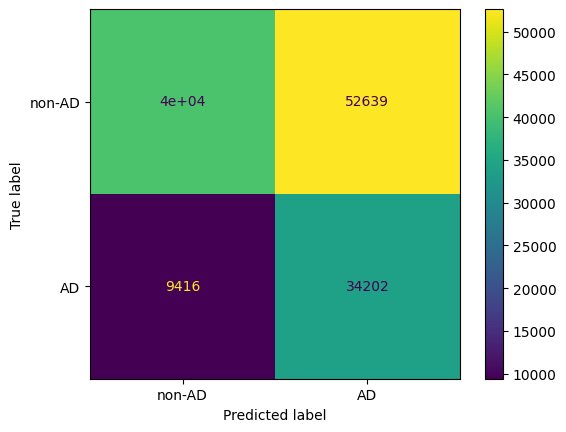

In [10]:
ConfusionMatrixDisplay(cm, display_labels=["non-AD", "AD"]).plot()

In [12]:
# Identify one-hot encoded columns
age_group_cols = [col for col in data_stimulated.columns if col.startswith('Age_Group')]
location_cols = [col for col in data_stimulated.columns if col.startswith('Location')]
sex_cols = [col for col in data_stimulated.columns if col.startswith('Sex')]
race_cols = [col for col in data_stimulated.columns if col.startswith('Race_code')]

# Identify other columns
other_cols = [col for col in data_stimulated.columns if col not in age_group_cols + location_cols + sex_cols + race_cols ] # + ["HAS_ALZHEIMERS"]

# Generate a sample of combinations for one-hot encoded columns without using product
def generate_combinations(sample_size=1000):
    for _ in range(sample_size):
        age_bits = [rng.choice([0, 1]) for _ in range(len(age_group_cols))]
        loc_bits = [rng.choice([0, 1]) for _ in range(len(location_cols))]
        sex_bits = [rng.choice([0, 1]) for _ in range(len(sex_cols))]
        race_bits = [rng.choice([0, 1]) for _ in range(len(race_cols))]
        other_bits = [rng.choice([0, 1]) for _ in range(len(other_cols))]
        yield age_bits + loc_bits + sex_bits + race_bits + other_bits

# Create a DataFrame with a sample of combinations using lazy generation
variable_checker = pd.DataFrame(generate_combinations(), columns=data_stimulated.columns)

In [13]:
if "Oral health:  tooth retention" in variable_checker.columns:
    variable_checker = variable_checker.drop(["Oral health:  tooth retention"], axis=1)
variable_checker["Predicted"] = tuned_model.predict(variable_checker.drop("HAS_ALZHEIMERS", axis=1))

In [14]:
variable_checker.columns

Index(['HAS_ALZHEIMERS', 'Frequent mental distress',
       'Prevalence of sufficient sleep', 'Eating 2 or more fruits daily',
       'Eating 3 or more vegetables daily', 'Lifetime diagnosis of depression',
       'Obesity', 'Fall with injury within last year', 'Age_Group_50-64 years',
       'Age_Group_65 years or older', 'Age_Group_Overall', 'Location_Alabama',
       'Location_Alaska', 'Location_Arizona', 'Location_Arkansas',
       'Location_California', 'Location_Colorado', 'Location_Connecticut',
       'Location_Delaware', 'Location_District of Columbia',
       'Location_Florida', 'Location_Georgia', 'Location_Hawaii',
       'Location_Idaho', 'Location_Illinois', 'Location_Indiana',
       'Location_Iowa', 'Location_Kansas', 'Location_Kentucky',
       'Location_Louisiana', 'Location_Maine', 'Location_Maryland',
       'Location_Massachusetts', 'Location_Michigan', 'Location_Minnesota',
       'Location_Mississippi', 'Location_Missouri', 'Location_Montana',
       'Location_Ne

In [15]:
state_to_abbreviation = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", "Colorado": "CO",
    "Connecticut": "CT", "Delaware": "DE", "District of Columbia": "DC", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI",
    "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA",
    "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS",
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ",
    "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD",
    "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA",
    "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY"
}


In [16]:
age_values = ["Overall", "50-64 years", "65 years or older"]
state_values = list(state_to_abbreviation.keys())
race_values = ["Hispanic", "White", "Black", "Native American", "Asian", "Native American"]

# Corrected map_category_to_vals dictionary
map_category_to_vals = {
    'AGE_GROUP': age_values,
    'NAME': state_values, 
    'SEX': {
        0: "All genders", 
        1: "Male", 
        2: "Female"
    }, 
    'RACE': race_values, 
    'Frequent mental distress': None, 
    'Prevalence of sufficient sleep': None, 
    'Eating 2 or more fruits daily': None, 
    'Eating 3 or more vegetables daily': None, 
    'Lifetime diagnosis of depression': None, 
    'Obesity': None, 
    'Fall with injury within last year': None,
}

def get_factor_string(factor: str, val: int) -> str:
    if not map_category_to_vals[factor]:
        return f'{factor}: {"Present" if val == 1 else "Absent"}'
    if factor == "NAME":
        return map_category_to_vals[factor][val]
    return f'{factor}: {map_category_to_vals[factor][val]}'

In [18]:
variable_checker = variable_checker.drop_duplicates()
plotting_data = []
state_data = []

unique_values = {
    "Age_Group": age_values,
    "Location": state_values,
    "Sex": list(pop_sex_to_stratified.values()),
    "Race_code": list(pop_race_to_stratified.values()),
    "Frequent mental distress": [0, 1],
    "Prevalence of sufficient sleep": [0, 1],
    "Eating 2 or more fruits daily": [0, 1],
    "Eating 3 or more vegetables daily": [0, 1],
    "Lifetime diagnosis of depression": [0, 1],
    "Obesity": [0, 1],
    "Fall with injury within last year": [0, 1]
}

try:
    unique_values.pop("HAS_ALZHEIMERS")    
except KeyError:
    print('"HAS_ALZHEIMERS" not in unique_values')
try:
    unique_values.pop("Oral health:  tooth retention")
except KeyError:
    print('"Oral health: tooth retention" not in unique_values')

for factor, values in unique_values.items():
    for value in values:
        if factor in ['Age_Group', 'Location', 'Sex', 'Race_code']:
            column_name = f"{factor}_{value}"
        else:
            column_name = factor
        
        variable_checker_subset = variable_checker[(variable_checker[column_name] == 1) & (variable_checker["HAS_ALZHEIMERS"] == 1)]
        current_data = (
            get_factor_string(factor, value), 
            variable_checker_subset[variable_checker_subset["Predicted"] == 1]["Predicted"].sum() / variable_checker_subset["Predicted"].count() * 100
        )
        if factor != "Location":
            plotting_data.append(current_data)
        else:
            state_data.append(current_data)
        print(f'People with the characteristic "{current_data[0]}" have {current_data[1]}% chance of having AD')


"HAS_ALZHEIMERS" not in unique_values
"Oral health: tooth retention" not in unique_values


KeyError: 'Age_Group'

In [ ]:
labels = [
    "AGE_GROUP", "SEX", "RACE", "Frequent mental distress", 
    "Prevalence of sufficient sleep", "Eating 2 or more fruits daily", 
    "Eating 3 or more vegetables daily", "Lifetime diagnosis of depression", 
    "Obesity", "Fall with injury within last year"
]

pairs = [
    ("AGE_GROUP: 50-64 years", "AGE_GROUP: 65 years or older", "AGE_GROUP: Overall"),
    ("SEX: All genders", "SEX: Male", "SEX: Female"),
    ("RACE: Hispanic", "RACE: White", "RACE: Black", "RACE: Native American", "RACE: Asian", "RACE: Native American"),
    ("Frequent mental distress: Present", "Frequent mental distress: Absent"),
    ("Prevalence of sufficient sleep: Present", "Prevalence of sufficient sleep: Absent"),
    ("Eating 2 or more fruits daily: Absent", "Eating 2 or more fruits daily: Present"),
    ("Eating 3 or more vegetables daily: Absent", "Eating 3 or more vegetables daily: Present"),
    ("Lifetime diagnosis of depression: Absent", "Lifetime diagnosis of depression: Present"),
    ("Obesity: Present", "Obesity: Absent"),
    ("Fall with injury within last year: Present", "Fall with injury within last year: Absent")
]

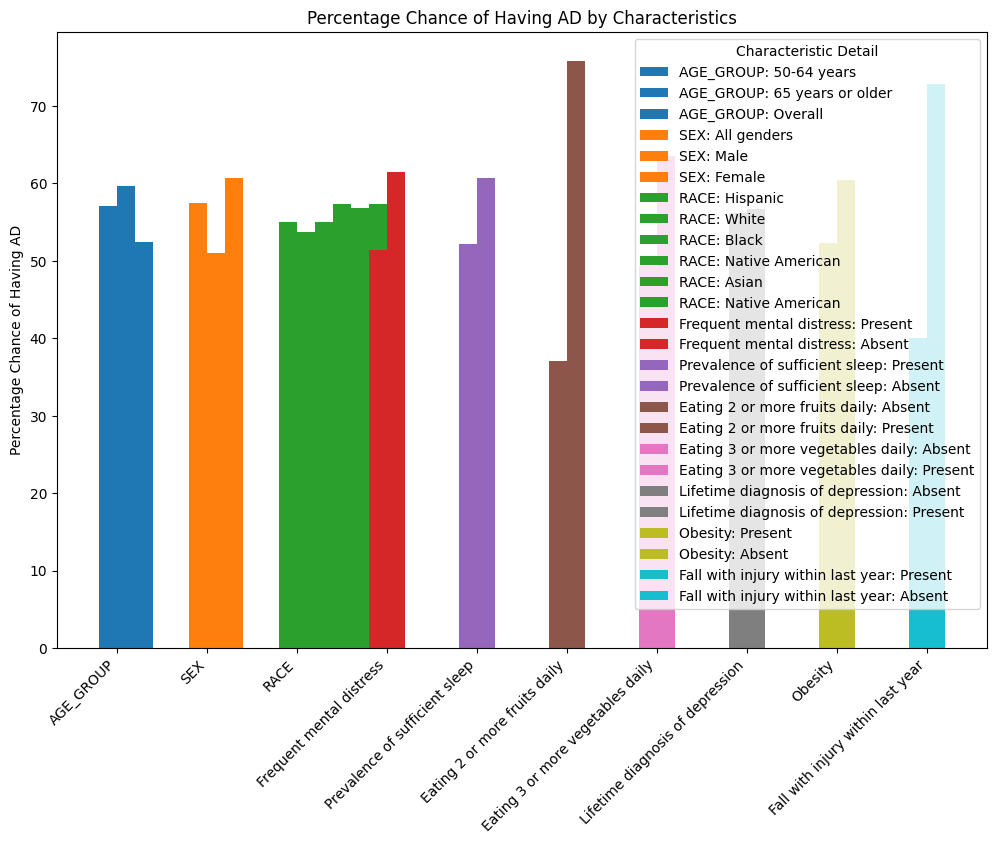

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
for idx, group in enumerate(pairs):
    values = [next((item[1] for item in plotting_data if item[0] == characteristic), 0) for characteristic in group]
    positions = [idx * 2 + i * 0.4 for i in range(len(group))]
    ax.bar(positions, values, width=0.4, label=group)

    ax.set_ylabel('Percentage Chance of Having AD')
ax.set_title('Percentage Chance of Having AD by Characteristics')
ax.set_xticks([i * 2 + 0.2 for i in range(len(pairs))])
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend(title="Characteristic Detail")

plt.show()

In [ ]:
state_to_abbreviation = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "District of Columbia": "DC",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY"
}

In [ ]:
states = [state_to_abbreviation[item[0]] for item in state_data]
values = [item[1] for item in state_data]

In [ ]:
state_fig = go.Figure(data=go.Choropleth(
    locations=states,  # Spatial coordinates
    z=values,  # Data to be color-coded
    locationmode='USA-states',  # set of locations match entries in `locations`
    colorscale='Blues',
    # colorbar_title="Percentage Chance of Having AD",
))

state_fig.update_layout(
    # title_text='Percentage Chance of Having Alzheimer\'s Disease by State',
    geo_scope='usa',  # limit map scope to USA
)

state_fig.show()

In [40]:
data_stimulated["Predicted1"] = tuned_model.predict(data_stimulated.drop(["HAS_ALZHEIMERS", "Oral health:  tooth retention"], axis=1))

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

tuned_models = {
    'lr_saga_l2': LogisticRegression(
        penalty="l2",
        solver="saga",
        random_state=int(rng.random() * 280741231)),
    'gb': GradientBoostingClassifier(        
        random_state=int(rng.random() * 280741231)),
    'rf': RandomForestClassifier(
        random_state=int(rng.random() * 280741231)),
    'knn': KNeighborsClassifier(
        n_neighbors=2)
}

In [29]:
for model_name, model in tuned_models.items():
    tuned_models[model_name] = TunedThresholdClassifierCV(
        model,
        n_jobs=-1
    )
    model = tuned_models[model_name]
    model.fit(X_train, y_train)
    accuracy = accuracy_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))
    print(f'{model_name} accuracy: {accuracy}, f1: {f1}, precision: {precision}, recall: {recall}')

lr_saga_l2 accuracy: 0.6581702121429512, f1: 0.5213906483816083, precision: 0.4708005552984729, recall: 0.5841620541558531
gb accuracy: 0.6692531806802043, f1: 0.5283223718550997, precision: 0.4842963501693812, recall: 0.581153395650077
rf accuracy: 0.6536316120814606, f1: 0.5156515508240352, precision: 0.46514247723873015, recall: 0.5784662731678188
knn accuracy: 0.5670468354245055, f1: 0.4727852953236705, precision: 0.3863434390524614, recall: 0.6090581291196803


gb accuracy: 0.6692531806802043, f1: 0.5283223718550997, precision: 0.4842963501693812, recall: 0.581153395650077

rf accuracy: 0.6536316120814606, f1: 0.5156515508240352, precision: 0.46514247723873015, recall: 0.5784662731678188

lr_saga_l2 accuracy: 0.6561278421152804, f1: 0.5201393358054202, precision: 0.46773837957009, recall: 0.5857626026735384

lr_nc_l2 accuracy: 0.6561644437286795, f1: 0.5200972679158918, precision: 0.46777306059436513, recall: 0.5856015461426961

lr_ncg_l2 accuracy: 0.6561644437286795, f1: 0.5200972679158918, precision: 0.46777306059436513, recall: 0.5856015461426961

lr_lbfgs_l2 accuracy: 0.6561644437286795, f1: 0.5199991824554949, precision: 0.46776121049438324, recall: 0.5853714653843499

lr_liblinear_l1 accuracy: 0.6561644437286795, f1: 0.5200972679158918, precision: 0.46777306059436513, recall: 0.5856015461426961

knn accuracy: 0.5670468354245055, f1: 0.4727852953236705, precision: 0.3863434390524614, recall: 0.6090581291196803

In [63]:
from sklearn.neural_network import MLPClassifier


tuned_model2 = MLPClassifier(hidden_layer_sizes=1024, random_state=int(rng.random() * 280741231))

In [64]:
tuned_model2.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=1024, random_state=207612098)

In [65]:
accuracy_score(y_test, tuned_model2.predict(X_test)), f1_score(y_test, tuned_model2.predict(X_test)), precision_score(y_test, tuned_model2.predict(X_test)), recall_score(y_test, tuned_model2.predict(X_test))

(0.7306706879639254,
 0.46517036864751715,
 0.6355511420059583,
 0.3668294472338767)

In [30]:
tuned_models["mlp"] = tuned_model2

In [8]:
from sklearn.ensemble import HistGradientBoostingClassifier


a_model = TunedThresholdClassifierCV(
    HistGradientBoostingClassifier(),
    scoring="f1",
    n_jobs=-1
)

In [9]:
a_model.fit(X_train, y_train)

TunedThresholdClassifierCV(estimator=HistGradientBoostingClassifier(),
                           n_jobs=-1, scoring='f1')

In [10]:
from sklearn.metrics import classification_report


print(classification_report(y_test, a_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.54      0.65     93065
           1       0.43      0.75      0.55     43541

    accuracy                           0.60    136606
   macro avg       0.62      0.64      0.60    136606
weighted avg       0.70      0.60      0.62    136606



In [11]:
a_model.score(X_test, y_test)

0.6038241365679399

In [13]:
fn

Index(['AGE_GROUP', 'NAME', 'SEX', 'RACE', 'Frequent mental distress',
       'Prevalence of sufficient sleep', 'Eating 2 or more fruits daily',
       'Eating 3 or more vegetables daily', 'Lifetime diagnosis of depression',
       'Obesity', 'Fall with injury within last year'],
      dtype='object')

In [18]:
a_model.predict([[2, 43, 1, 4, 0, 1, 0, 0, 0, 0, 0]])

/opt/homebrew/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(


array([1])

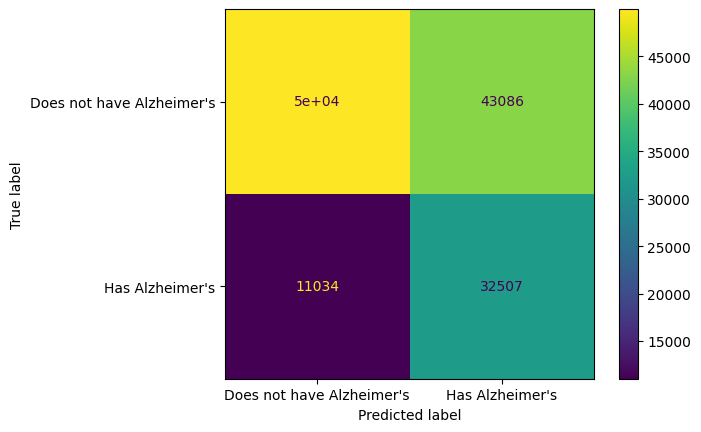

In [12]:
cm = confusion_matrix(y_test, a_model.predict(X_test))
ConfusionMatrixDisplay(cm, display_labels=["Does not have Alzheimer's", "Has Alzheimer's"]).plot()

In [40]:
features = X.columns
features

Index(['AGE_GROUP', 'NAME', 'SEX', 'RACE', 'Frequent mental distress',
       'Prevalence of sufficient sleep', 'Eating 2 or more fruits daily',
       'Eating 3 or more vegetables daily', 'Lifetime diagnosis of depression',
       'Obesity', 'Fall with injury within last year'],
      dtype='object')

In [42]:
for model_name, model in tuned_models.items():
    data_stimulated[f"Predicted_{model_name}"] = model.predict(data_stimulated[features])

In [55]:
data_stimulated[["Predicted_lr_saga_l2", "Predicted_gb", "Predicted_rf", "Predicted_knn", "Predicted_mlp"]].sum(axis=1).value_counts()

0    444255
5    308791
1    268393
4    136295
2    114653
3     93666
Name: count, dtype: int64

In [43]:
X = data_stimulated.drop(["HAS_ALZHEIMERS", "Oral health:  tooth retention"], axis=1) # , "Oral health:  tooth retention"
y = data_stimulated["HAS_ALZHEIMERS"]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=.1, 
    random_state=int(rng.random() * 280741231))

In [49]:
tuned_model.fit(X_train, y_train)

TunedThresholdClassifierCV(estimator=RandomForestClassifier(criterion='log_loss',
                                                            n_jobs=-1,
                                                            random_state=2000334825),
                           n_jobs=-1, store_cv_results=True)

In [50]:
accuracy_score(y_test, tuned_model.predict(X_test)), f1_score(y_test, tuned_model.predict(X_test)), precision_score(y_test, tuned_model.predict(X_test)), recall_score(y_test, tuned_model.predict(X_test))

(0.6625770463962052,
 0.5289705491630731,
 0.4771667189026751,
 0.5933924845816998)